In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

#Setup training Data
train_data = datasets.MNIST(
    root="data", # where to download data to ?
    train=True,  # do we want the training dataset?
    download=True, # do we want to download it?
    transform=torchvision.transforms.ToTensor(),  # how we want to transform the data?
    target_transform=None  # how do we want to transform the lables?
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

In [2]:
#Little bit of Data Exploration
image,label = train_data[0]
print(f"The shape of downloaded image is {image.shape} which is a Tensor object and the label is {label} which is an int object.")
print("------------------------")
print(f"Different classes in dataset we have are as follows :\n {train_data.classes}")
print("------------------------")
print(f"No. of (images,label) we have in training set is {len(train_data)}")
print("------------------------")
print(f"No. of (images,label) we have in test set is {len(test_data)}")

The shape of downloaded image is torch.Size([1, 28, 28]) which is a Tensor object and the label is 5 which is an int object.
------------------------
Different classes in dataset we have are as follows :
 ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
------------------------
No. of (images,label) we have in training set is 60000
------------------------
No. of (images,label) we have in test set is 10000


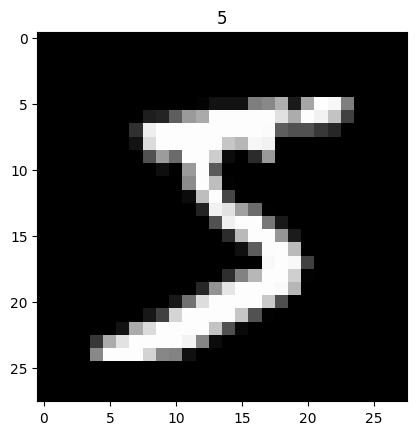

In [3]:
#Viewing our data
plt.imshow(image.squeeze(), cmap="gray")   #we're squeezing to remove that extra one dimension: [1,28,28] -> [28,28]
plt.title(label)
plt.show()

In [5]:
#For dividing training set into train and validation set
from torch.utils.data import random_split

# Define the lengths for training and validation
train_size = int(0.8 * len(train_data))  # 80% for training
val_size = len(train_data) - train_size   # 20% for validation

# Randomly split dataset
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

In [6]:
#Let's create a DataLoader's for our train, validation and test sets

from torch.utils.data import DataLoader

# Setup batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_dataset, # dataset to turn into iterable
                              batch_size=BATCH_SIZE,# how many samples per batch?
                              shuffle=True)# shuffle data every epoch?
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

#Let's checkout what we've created
print(f"Dataloaders: {train_dataloader,val_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of val dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")
print("------------------------")
print("DataLoader doesn't have a direct shape attribute because it’s more of an iterator and is not defined like a tensor, but its contents (the batches) do have shapes.")
print("------------------------")
for image,label in train_dataloader:
    print(f"Shape of image in a DataLoader is {image.shape}")
    print(f"Shape of label in a DataLoader is {label.shape}")
    break
print(f"Now see we have one more dimension in image that contains nothing but the batch size. \nAlso the label is now an 1D Tensor")


Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x0000022F91A444A0>, <torch.utils.data.dataloader.DataLoader object at 0x0000022F91A446B0>, <torch.utils.data.dataloader.DataLoader object at 0x0000022F91A45670>)
Length of train dataloader: 1500 batches of 32
Length of val dataloader: 375 batches of 32
Length of test dataloader: 313 batches of 32
------------------------
DataLoader doesn't have a direct shape attribute because it’s more of an iterator and is not defined like a tensor, but its contents (the batches) do have shapes.
------------------------
Shape of image in a DataLoader is torch.Size([32, 1, 28, 28])
Shape of label in a DataLoader is torch.Size([32])
Now see we have one more dimension in image that contains nothing but the batch size. 
Also the label is now an 1D Tensor


In [7]:
#Building a multi-class classification model
class ClassifyDigit(nn.Module):
  def __init__(self,input_features: int,output_features: int):
    """Initializes all required hyperparameters for a multi-class classification model.
    Args:
         input_features (int): Number of input features to the model.
         out_features (int)  : Number of output features of the model
                               (how many classes there are).
         hidden_units (int)  : Number of hidden units between layers, default 8.
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_features,out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128,out_features=60),
        nn.ReLU(),
        nn.Linear(in_features=60,out_features=30),
        nn.ReLU(),
        nn.Linear(in_features=30,out_features=output_features)
    )

  def forward(self,x):
    return self.linear_layer_stack(x)


In [8]:
# Creating an Instance of our Model.
model= ClassifyDigit(input_features=784,
                    output_features=len(train_data.classes))
model

ClassifyDigit(
  (linear_layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=60, bias=True)
    (4): ReLU()
    (5): Linear(in_features=60, out_features=30, bias=True)
    (6): ReLU()
    (7): Linear(in_features=30, out_features=10, bias=True)
  )
)

In [9]:
#Doing a Random Forward Pass
dummy_x = torch.rand([1,1,28,28])
y_test=model(dummy_x)   #in output we get 10 logits(one logit per class)
print(f"The model output is :\n{y_test}")
print("------------------------")
print("But we want the probabilities")
print("------------------------")
y_pred_probs = torch.softmax(y_test,dim=1)
print(f"Probability of each class is as follows:\n{y_pred_probs}")
print("------------------------")
print(f"Sum of all probabilities is : \n{torch.sum(y_pred_probs)}")
print(f"The maximum probability is of class: \n{torch.argmax(y_pred_probs)}")

The model output is :
tensor([[ 0.0242, -0.1113, -0.0577,  0.0282, -0.1867,  0.1251,  0.1329, -0.1127,
          0.1124, -0.0956]], grad_fn=<AddmmBackward0>)
------------------------
But we want the probabilities
------------------------
Probability of each class is as follows:
tensor([[0.1033, 0.0902, 0.0952, 0.1037, 0.0837, 0.1143, 0.1152, 0.0901, 0.1128,
         0.0916]], grad_fn=<SoftmaxBackward0>)
------------------------
Sum of all probabilities is : 
0.9999999403953552
The maximum probability is of class: 
6


In [10]:
#Setting up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=0.001)

In [11]:
from timeit import default_timer as timer

def print_train_time(start: float, end: float, device: torch.device = None):
    
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [12]:
# Set the seed and start the timer
torch.manual_seed(42)
train_time_start = timer()

# Set the number of epochs
epochs = 3
epoch_array=[]
train_loss_array=[]
val_loss_array=[]
# Create training and validation loop
for epoch in range(epochs):
  print(f"Epoch: {epoch}\n---------")
  epoch_array.append(epoch)
  ### Training
  train_loss=0
  val_loss=0
  # Add a loop to loop through training batches
  for batch, (X, y) in enumerate(train_dataloader):   # Train data loader is one which has 60000/32 batches ,, (X,y):(Image,Label) ,  enumerate for keeping the track of number of batches we've been through.
    model.train()
    # 1. Forward Pass
    y_train_logits = model(X)  #At this time we are feeding 32 images to our model.
    y_pred = torch.softmax(y_train_logits,dim=1).argmax(dim=1)
    # 2. Calculate the loss (per batch)
    loss = loss_fn(y_train_logits, y)
    train_loss += loss # accumulate train loss (this is train_loss over 32 images)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()
    #Optimizeter will update the parameter per batch rathen than per epoch.

    #Print out whats happening
    if batch%100 ==0:
      print(f"Looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples") #len(X)->32 i.e. our batch size

  # Divide total train loss by length of train dataloader
  train_loss /= len(train_dataloader)  #Average loss per epochs
  train_loss_array.append(train_loss.item())
  
  ### Testing on Validation set
  model.eval()
  with torch.inference_mode():
    for X_test,y_test in val_dataloader:
      #1. Forward pass
      test_logits = model(X_test)
      test_pred = torch.softmax(test_logits,dim=1).argmax(dim=1)
      #2. Calculate the loss (accumualatively)
      val_loss += loss_fn(test_logits,y_test)
    # Calculate the Test_Loss average per batch
    val_loss /= len(val_dataloader)
    val_loss_array.append(val_loss.item())
  # Print out what's happening

  print(f"\nTrain loss: {train_loss:.5f} | Test loss: {val_loss:.5f}\n")
  
#Calulate the training time omn "device"
train_time_end = timer()
total_train_time_model = print_train_time(start=train_time_start , end=train_time_end, device=str(next(model.parameters()).device))

Epoch: 0
---------
Looked at 0/48000 samples
Looked at 3200/48000 samples
Looked at 6400/48000 samples
Looked at 9600/48000 samples
Looked at 12800/48000 samples
Looked at 16000/48000 samples
Looked at 19200/48000 samples
Looked at 22400/48000 samples
Looked at 25600/48000 samples
Looked at 28800/48000 samples
Looked at 32000/48000 samples
Looked at 35200/48000 samples
Looked at 38400/48000 samples
Looked at 41600/48000 samples
Looked at 44800/48000 samples

Train loss: 0.36760 | Test loss: 0.18353

Epoch: 1
---------
Looked at 0/48000 samples
Looked at 3200/48000 samples
Looked at 6400/48000 samples
Looked at 9600/48000 samples
Looked at 12800/48000 samples
Looked at 16000/48000 samples
Looked at 19200/48000 samples
Looked at 22400/48000 samples
Looked at 25600/48000 samples
Looked at 28800/48000 samples
Looked at 32000/48000 samples
Looked at 35200/48000 samples
Looked at 38400/48000 samples
Looked at 41600/48000 samples
Looked at 44800/48000 samples

Train loss: 0.14437 | Test loss:

Epoch array 
[0, 1, 2]
Train Loss Array 
[0.3675994873046875, 0.14436542987823486, 0.10125651210546494]
Validation Loss Array 
[0.1835346817970276, 0.1310654580593109, 0.09913387894630432]


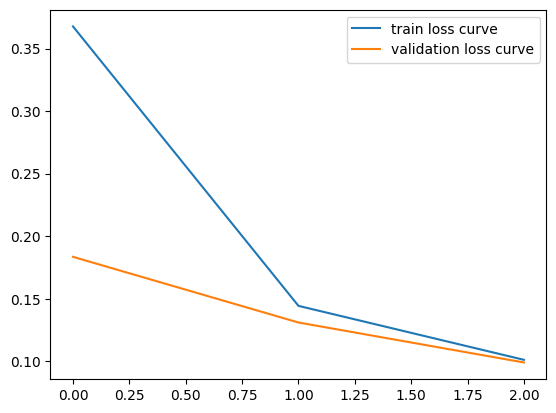

In [13]:
#Ploting error vs epoch
print(f"Epoch array \n{epoch_array}")
print(f"Train Loss Array \n{train_loss_array}")
print(f"Validation Loss Array \n{val_loss_array}")
plt.figure()
plt.plot(epoch_array,train_loss_array,label='train loss curve')
plt.plot(epoch_array,val_loss_array,label='validation loss curve')
plt.legend()

For Batch 0 
the predicted outputs are 
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 8, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1])
 and the original outputs are 
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1])
For Batch 100 
the predicted outputs are 
tensor([9, 2, 7, 1, 8, 8, 3, 2, 7, 6, 0, 1, 2, 7, 1, 0, 8, 3, 6, 0, 5, 3, 6, 2,
        8, 7, 0, 1, 4, 2, 1, 1])
 and the original outputs are 
tensor([9, 2, 7, 1, 8, 8, 8, 2, 7, 6, 0, 1, 2, 7, 1, 0, 8, 3, 6, 0, 5, 3, 6, 2,
        8, 7, 0, 1, 4, 2, 1, 1])
For Batch 200 
the predicted outputs are 
tensor([6, 9, 6, 8, 8, 5, 6, 1, 1, 9, 8, 9, 2, 3, 5, 5, 9, 4, 2, 1, 9, 3, 9, 2,
        0, 6, 0, 4, 0, 0, 1, 2])
 and the original outputs are 
tensor([0, 9, 6, 8, 8, 5, 6, 1, 1, 9, 8, 9, 2, 3, 5, 5, 9, 4, 2, 1, 9, 3, 9, 2,
        0, 6, 0, 4, 0, 0, 1, 2])
For Batch 300 
the predicted outputs are 
tensor([5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7

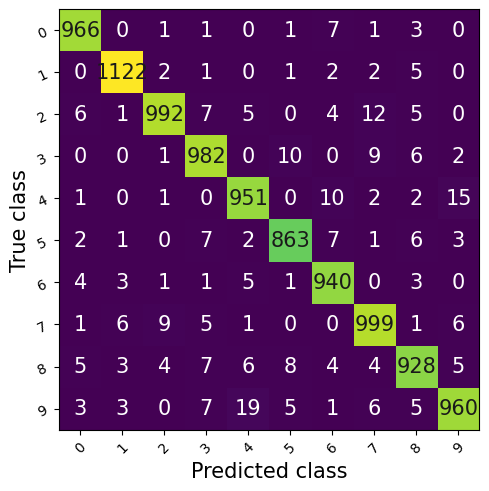

In [14]:
# Making Predictions
model.eval()
from torchmetrics import Accuracy
from torchmetrics.classification import MulticlassConfusionMatrix

accuracy_fn = Accuracy("multiclass",num_classes=10)
metric = MulticlassConfusionMatrix(num_classes=10)

overall_acc=0
y_pred=[]
y_true=[]

with torch.inference_mode():
  for batch,(x,y) in enumerate(test_dataloader):
    test_logits = model(x)
    test_pred = torch.softmax(test_logits,dim=1).argmax(dim=1)
    y_pred.append(test_pred)
    y_true.append(y)
    acc=accuracy_fn(test_pred,y)
    overall_acc+=acc
    if batch%100==0:
      print(f"For Batch {batch} \nthe predicted outputs are \n{test_pred}\n and the original outputs are \n{y}")
  print(f"\n \nThe overall Accuracy is {(overall_acc/len(test_dataloader))*100}%")
  y_pred = torch.cat(y_pred)
  y_true = torch.cat(y_true)
  metric(y_pred,y_true)
  metric.plot()

In [15]:
model.state_dict

<bound method Module.state_dict of ClassifyDigit(
  (linear_layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=60, bias=True)
    (4): ReLU()
    (5): Linear(in_features=60, out_features=30, bias=True)
    (6): ReLU()
    (7): Linear(in_features=30, out_features=10, bias=True)
  )
)>

Weights shape: torch.Size([128, 784])


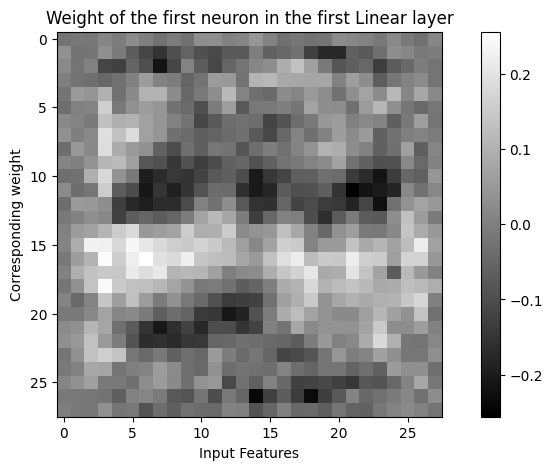

In [42]:
#Visualizing what neuron is trying to learn

linear_layer_weights = model.linear_layer_stack[1].weight.data  # Extract weight tensor

print(f"Weights shape: {linear_layer_weights.shape}")

plt.figure(figsize=(10, 5))
plt.imshow(linear_layer_weights[30,:].view(28,28).numpy(),cmap='gray')
plt.colorbar()
plt.title('Weight of the first neuron in the first Linear layer')
plt.xlabel('Input Features')
plt.ylabel('Corresponding weight')
plt.show()